# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

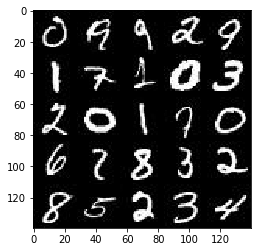

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

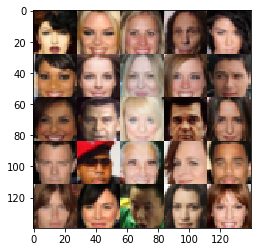

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
# Adding a function for leaky RELU

def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
     return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # The structure of the discriminator is the reverse of the generator network defined below
    # Following the steps in the DCGAN lecture video
    # The paramaeter alpha for leaky RELU is not passed, so we just set it to the value used in the DCGAN lecture
    
  #  alpha = 0.2
    keep_prob = 0.3
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Adding another layer as per reviewer feedback. Also using Xavier Initializer
        # Also, as per second review, reducing size of discriminator relative to generator
        
        # Input layer is 28x28x3
        # Output: 28x28x32
        
        x11 = tf.layers.conv2d(images, 32, 5, strides=1, padding='same', 
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu11 = leaky_relu(x11)
        relu11 = tf.layers.dropout(relu11, keep_prob, training=True)
        
        # Input layer is 28x28x32
        # Output: # 14x14x64
        
        x1 = tf.layers.conv2d(relu11, 64, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = leaky_relu(bn1)
        relu1 = tf.layers.dropout(relu1, keep_prob, training=True)
        
        # Input layer is 14x14x64
        # Output: 7x7x128
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        relu2 = tf.layers.dropout(relu2, keep_prob, training=True)
        
        # Input layer is: 7x7x128
        # Output: 2x2x256
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        relu3 = tf.layers.dropout(relu3, keep_prob, training=True)
        
        # Flatten x3
        # Input: 2x2x256
        # Output: 2*2*256
        
        flat = tf.reshape(relu3, (-1, 2*2*256))
        
        # Dense layer
        # Input: 2*2*256
        # Output: 1
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # The paramaeter alpha is not passed, so we just set it to the value used in the DCGAN lecture
    
 #   alpha = 0.2
    reuse = not is_train
    keep_prob = 0.3
    
    with tf.variable_scope('generator', reuse=reuse):
         
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        # 2x2x512 now
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
       
        # After several tries, I got the a hint from the forums that for everything to work out 
        # at the last layer, need to go from 2x2 to 7x7, and of course half the depth. However, 
        # second reviewer suggested that sharp decline in depth of generator from 512 to 128 is better
        
        # input: 2x2x512
        # output: 7x7x64
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        
        # Adding a dropout after dense and conv2d layers as recommended by reviewers
        
        x2 = tf.layers.dropout(x2, keep_prob, training=is_train)
        
        # input: 7x7x64
        # output: 14x14x64
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        
        # Based on reviewer feedback, adding another conv2d layer.
        # What we have below is what we did with discriminator at the first layer
        # Since the width and height are the same, we set strides = 1
        
        # input: 14x14x64
        # output: 14x14x32
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)
        
        # Output layer
        # Input: 14x14x32
        # Output: 28x28xout_channel_dim
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Borrowed code from DCGAN implementation
    
    # Incorporated reveiwer feedback by removing incorrect label smoothing implementation
    # * np.random.uniform()
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
        
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
      
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                steps += 1
                
                #Rescaling images
                
                # batch_images = 2.0*batch_images - 1
                
                batch_images = 2.0*batch_images
                
                # Sample Random Noise for Generator
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                
       #         print("Starting first sess.run")
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
        #        print("Starting second sess.run")
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
             ##       show_generator_output(sess, 25, batch_z, data_shape[3], data_image_mode)
        
    return None
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 0.6614... Generator Loss: 2.0532
Epoch 1/2 Batch# 20... Discriminator Loss: 0.5356... Generator Loss: 2.4999
Epoch 1/2 Batch# 30... Discriminator Loss: 1.0045... Generator Loss: 2.1525
Epoch 1/2 Batch# 40... Discriminator Loss: 0.7698... Generator Loss: 2.6226
Epoch 1/2 Batch# 50... Discriminator Loss: 0.9915... Generator Loss: 1.3972
Epoch 1/2 Batch# 60... Discriminator Loss: 0.6774... Generator Loss: 2.9087
Epoch 1/2 Batch# 70... Discriminator Loss: 0.5312... Generator Loss: 3.4157
Epoch 1/2 Batch# 80... Discriminator Loss: 0.5333... Generator Loss: 2.8318
Epoch 1/2 Batch# 90... Discriminator Loss: 0.5833... Generator Loss: 3.4849
Epoch 1/2 Batch# 100... Discriminator Loss: 0.5011... Generator Loss: 4.3366


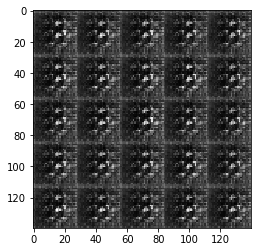

Epoch 1/2 Batch# 110... Discriminator Loss: 0.6433... Generator Loss: 2.6757
Epoch 1/2 Batch# 120... Discriminator Loss: 0.7073... Generator Loss: 2.6980
Epoch 1/2 Batch# 130... Discriminator Loss: 0.5248... Generator Loss: 3.5730
Epoch 1/2 Batch# 140... Discriminator Loss: 0.5012... Generator Loss: 3.4983
Epoch 1/2 Batch# 150... Discriminator Loss: 0.6297... Generator Loss: 2.9665
Epoch 1/2 Batch# 160... Discriminator Loss: 0.4700... Generator Loss: 4.1528
Epoch 1/2 Batch# 170... Discriminator Loss: 0.5265... Generator Loss: 4.3102
Epoch 1/2 Batch# 180... Discriminator Loss: 0.4663... Generator Loss: 5.1337
Epoch 1/2 Batch# 190... Discriminator Loss: 0.5024... Generator Loss: 3.0540
Epoch 1/2 Batch# 200... Discriminator Loss: 0.5904... Generator Loss: 3.0417


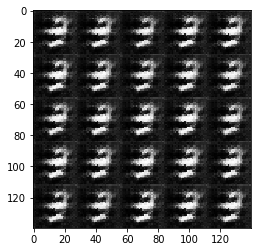

Epoch 1/2 Batch# 210... Discriminator Loss: 0.5802... Generator Loss: 3.5999
Epoch 1/2 Batch# 220... Discriminator Loss: 0.5007... Generator Loss: 3.5934
Epoch 1/2 Batch# 230... Discriminator Loss: 0.5910... Generator Loss: 2.9329
Epoch 1/2 Batch# 240... Discriminator Loss: 0.5697... Generator Loss: 3.0409
Epoch 1/2 Batch# 250... Discriminator Loss: 0.5219... Generator Loss: 3.9829
Epoch 1/2 Batch# 260... Discriminator Loss: 0.4794... Generator Loss: 3.2273
Epoch 1/2 Batch# 270... Discriminator Loss: 0.4949... Generator Loss: 3.1362
Epoch 1/2 Batch# 280... Discriminator Loss: 0.5637... Generator Loss: 3.1844
Epoch 1/2 Batch# 290... Discriminator Loss: 0.4297... Generator Loss: 4.4025
Epoch 1/2 Batch# 300... Discriminator Loss: 0.4622... Generator Loss: 4.7947


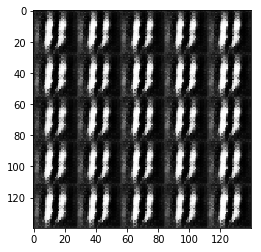

Epoch 1/2 Batch# 310... Discriminator Loss: 0.6058... Generator Loss: 5.3624
Epoch 1/2 Batch# 320... Discriminator Loss: 0.5749... Generator Loss: 3.1940
Epoch 1/2 Batch# 330... Discriminator Loss: 0.4369... Generator Loss: 4.3261
Epoch 1/2 Batch# 340... Discriminator Loss: 0.5106... Generator Loss: 2.7103
Epoch 1/2 Batch# 350... Discriminator Loss: 0.4949... Generator Loss: 3.6502
Epoch 1/2 Batch# 360... Discriminator Loss: 0.4563... Generator Loss: 4.2380
Epoch 1/2 Batch# 370... Discriminator Loss: 0.4245... Generator Loss: 4.2538
Epoch 1/2 Batch# 380... Discriminator Loss: 0.6469... Generator Loss: 1.6537
Epoch 1/2 Batch# 390... Discriminator Loss: 0.4577... Generator Loss: 4.0142
Epoch 1/2 Batch# 400... Discriminator Loss: 0.4027... Generator Loss: 4.7199


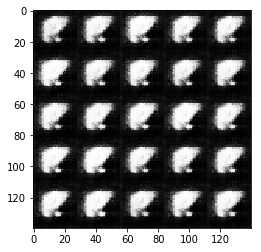

Epoch 1/2 Batch# 410... Discriminator Loss: 0.4193... Generator Loss: 4.4762
Epoch 1/2 Batch# 420... Discriminator Loss: 0.4268... Generator Loss: 3.8930
Epoch 1/2 Batch# 430... Discriminator Loss: 0.4339... Generator Loss: 4.6337
Epoch 1/2 Batch# 440... Discriminator Loss: 0.3847... Generator Loss: 4.9225
Epoch 1/2 Batch# 450... Discriminator Loss: 0.3887... Generator Loss: 5.0544
Epoch 1/2 Batch# 460... Discriminator Loss: 0.3834... Generator Loss: 4.5606
Epoch 1/2 Batch# 470... Discriminator Loss: 0.4142... Generator Loss: 3.9893
Epoch 1/2 Batch# 480... Discriminator Loss: 0.4964... Generator Loss: 2.8468
Epoch 1/2 Batch# 490... Discriminator Loss: 0.4099... Generator Loss: 4.1813
Epoch 1/2 Batch# 500... Discriminator Loss: 0.4912... Generator Loss: 2.9565


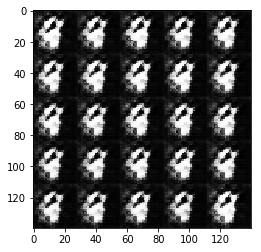

Epoch 1/2 Batch# 510... Discriminator Loss: 0.4435... Generator Loss: 4.0224
Epoch 1/2 Batch# 520... Discriminator Loss: 0.4212... Generator Loss: 4.2739
Epoch 1/2 Batch# 530... Discriminator Loss: 0.4602... Generator Loss: 3.2744
Epoch 1/2 Batch# 540... Discriminator Loss: 0.4659... Generator Loss: 4.3891
Epoch 1/2 Batch# 550... Discriminator Loss: 0.4539... Generator Loss: 4.3143
Epoch 1/2 Batch# 560... Discriminator Loss: 0.4118... Generator Loss: 4.1277
Epoch 1/2 Batch# 570... Discriminator Loss: 0.4312... Generator Loss: 3.8661
Epoch 1/2 Batch# 580... Discriminator Loss: 0.4532... Generator Loss: 2.8391
Epoch 1/2 Batch# 590... Discriminator Loss: 0.4391... Generator Loss: 4.0476
Epoch 1/2 Batch# 600... Discriminator Loss: 0.4692... Generator Loss: 3.9046


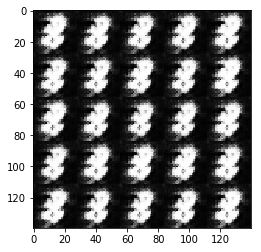

Epoch 1/2 Batch# 610... Discriminator Loss: 0.4244... Generator Loss: 3.8562
Epoch 1/2 Batch# 620... Discriminator Loss: 0.4505... Generator Loss: 3.9432
Epoch 1/2 Batch# 630... Discriminator Loss: 0.4587... Generator Loss: 3.4478
Epoch 1/2 Batch# 640... Discriminator Loss: 0.4193... Generator Loss: 4.3719
Epoch 1/2 Batch# 650... Discriminator Loss: 0.5110... Generator Loss: 2.7251
Epoch 1/2 Batch# 660... Discriminator Loss: 0.4168... Generator Loss: 3.9395
Epoch 1/2 Batch# 670... Discriminator Loss: 0.4029... Generator Loss: 4.3065
Epoch 1/2 Batch# 680... Discriminator Loss: 0.4522... Generator Loss: 3.5285
Epoch 1/2 Batch# 690... Discriminator Loss: 0.4166... Generator Loss: 3.8827
Epoch 1/2 Batch# 700... Discriminator Loss: 0.3939... Generator Loss: 4.7655


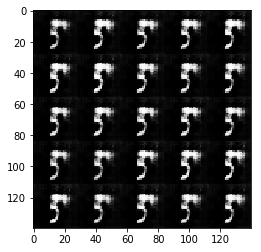

Epoch 1/2 Batch# 710... Discriminator Loss: 0.4033... Generator Loss: 4.3374
Epoch 1/2 Batch# 720... Discriminator Loss: 0.4021... Generator Loss: 4.4786
Epoch 1/2 Batch# 730... Discriminator Loss: 0.4116... Generator Loss: 4.4482
Epoch 1/2 Batch# 740... Discriminator Loss: 0.4644... Generator Loss: 3.2281
Epoch 1/2 Batch# 750... Discriminator Loss: 0.4203... Generator Loss: 4.5768
Epoch 1/2 Batch# 760... Discriminator Loss: 0.4313... Generator Loss: 4.8459
Epoch 1/2 Batch# 770... Discriminator Loss: 0.4100... Generator Loss: 4.0916
Epoch 1/2 Batch# 780... Discriminator Loss: 0.4020... Generator Loss: 4.4089
Epoch 1/2 Batch# 790... Discriminator Loss: 0.4180... Generator Loss: 3.9889
Epoch 1/2 Batch# 800... Discriminator Loss: 0.5584... Generator Loss: 2.9603


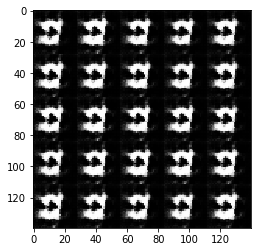

Epoch 1/2 Batch# 810... Discriminator Loss: 0.4239... Generator Loss: 4.4457
Epoch 1/2 Batch# 820... Discriminator Loss: 0.3793... Generator Loss: 5.1787
Epoch 1/2 Batch# 830... Discriminator Loss: 0.3666... Generator Loss: 5.0493
Epoch 1/2 Batch# 840... Discriminator Loss: 0.4418... Generator Loss: 3.4733
Epoch 1/2 Batch# 850... Discriminator Loss: 0.3768... Generator Loss: 4.8275
Epoch 1/2 Batch# 860... Discriminator Loss: 0.3702... Generator Loss: 4.7314
Epoch 1/2 Batch# 870... Discriminator Loss: 0.3880... Generator Loss: 4.5031
Epoch 1/2 Batch# 880... Discriminator Loss: 0.3791... Generator Loss: 4.4589
Epoch 1/2 Batch# 890... Discriminator Loss: 0.4924... Generator Loss: 2.8828
Epoch 1/2 Batch# 900... Discriminator Loss: 0.3813... Generator Loss: 4.3511


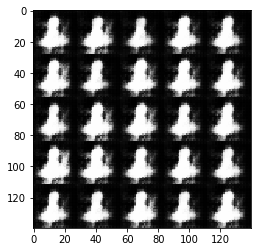

Epoch 1/2 Batch# 910... Discriminator Loss: 0.4167... Generator Loss: 3.8584
Epoch 1/2 Batch# 920... Discriminator Loss: 0.4545... Generator Loss: 3.5121
Epoch 1/2 Batch# 930... Discriminator Loss: 0.4446... Generator Loss: 3.5323
Epoch 2/2 Batch# 10... Discriminator Loss: 0.4209... Generator Loss: 3.3006
Epoch 2/2 Batch# 20... Discriminator Loss: 0.4259... Generator Loss: 3.5913
Epoch 2/2 Batch# 30... Discriminator Loss: 0.4369... Generator Loss: 4.5351
Epoch 2/2 Batch# 40... Discriminator Loss: 0.3905... Generator Loss: 4.7274
Epoch 2/2 Batch# 50... Discriminator Loss: 0.4178... Generator Loss: 3.8092
Epoch 2/2 Batch# 60... Discriminator Loss: 0.3774... Generator Loss: 4.9635
Epoch 2/2 Batch# 70... Discriminator Loss: 0.3834... Generator Loss: 4.6764
Epoch 2/2 Batch# 80... Discriminator Loss: 0.4060... Generator Loss: 4.8525
Epoch 2/2 Batch# 90... Discriminator Loss: 0.3875... Generator Loss: 4.3790
Epoch 2/2 Batch# 100... Discriminator Loss: 0.4066... Generator Loss: 3.6648


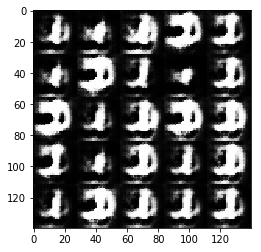

Epoch 2/2 Batch# 110... Discriminator Loss: 0.3775... Generator Loss: 4.6736
Epoch 2/2 Batch# 120... Discriminator Loss: 0.4610... Generator Loss: 2.9534
Epoch 2/2 Batch# 130... Discriminator Loss: 0.4070... Generator Loss: 4.2275
Epoch 2/2 Batch# 140... Discriminator Loss: 0.4168... Generator Loss: 4.0601
Epoch 2/2 Batch# 150... Discriminator Loss: 0.3994... Generator Loss: 4.6759
Epoch 2/2 Batch# 160... Discriminator Loss: 0.5022... Generator Loss: 2.9223
Epoch 2/2 Batch# 170... Discriminator Loss: 0.4325... Generator Loss: 3.1120
Epoch 2/2 Batch# 180... Discriminator Loss: 0.4612... Generator Loss: 3.6219
Epoch 2/2 Batch# 190... Discriminator Loss: 0.4205... Generator Loss: 3.4197
Epoch 2/2 Batch# 200... Discriminator Loss: 0.4019... Generator Loss: 5.2497


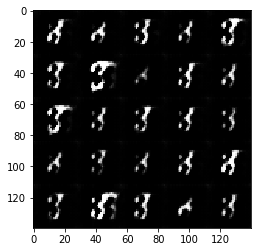

Epoch 2/2 Batch# 210... Discriminator Loss: 0.4491... Generator Loss: 4.3220
Epoch 2/2 Batch# 220... Discriminator Loss: 0.4912... Generator Loss: 3.4574
Epoch 2/2 Batch# 230... Discriminator Loss: 0.4127... Generator Loss: 4.1230
Epoch 2/2 Batch# 240... Discriminator Loss: 0.3958... Generator Loss: 4.7808
Epoch 2/2 Batch# 250... Discriminator Loss: 0.4635... Generator Loss: 3.0305
Epoch 2/2 Batch# 260... Discriminator Loss: 0.4214... Generator Loss: 3.6772
Epoch 2/2 Batch# 270... Discriminator Loss: 0.3666... Generator Loss: 5.7975
Epoch 2/2 Batch# 280... Discriminator Loss: 0.4566... Generator Loss: 3.9791
Epoch 2/2 Batch# 290... Discriminator Loss: 0.3751... Generator Loss: 4.4704
Epoch 2/2 Batch# 300... Discriminator Loss: 0.4068... Generator Loss: 3.8129


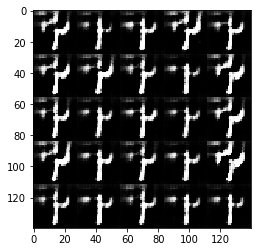

Epoch 2/2 Batch# 310... Discriminator Loss: 0.4293... Generator Loss: 3.0728
Epoch 2/2 Batch# 320... Discriminator Loss: 0.4390... Generator Loss: 3.3311
Epoch 2/2 Batch# 330... Discriminator Loss: 0.5014... Generator Loss: 5.0402
Epoch 2/2 Batch# 340... Discriminator Loss: 0.3953... Generator Loss: 4.4999
Epoch 2/2 Batch# 350... Discriminator Loss: 0.4247... Generator Loss: 3.7255
Epoch 2/2 Batch# 360... Discriminator Loss: 0.4362... Generator Loss: 3.2489
Epoch 2/2 Batch# 370... Discriminator Loss: 0.4033... Generator Loss: 4.5229
Epoch 2/2 Batch# 380... Discriminator Loss: 0.5536... Generator Loss: 2.6357
Epoch 2/2 Batch# 390... Discriminator Loss: 0.5540... Generator Loss: 2.3176
Epoch 2/2 Batch# 400... Discriminator Loss: 0.7209... Generator Loss: 1.7833


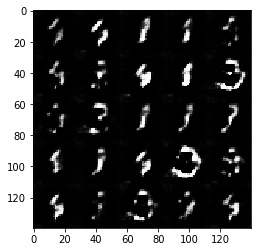

Epoch 2/2 Batch# 410... Discriminator Loss: 0.4870... Generator Loss: 3.2843
Epoch 2/2 Batch# 420... Discriminator Loss: 0.5650... Generator Loss: 3.1112
Epoch 2/2 Batch# 430... Discriminator Loss: 0.4560... Generator Loss: 4.2887
Epoch 2/2 Batch# 440... Discriminator Loss: 0.6053... Generator Loss: 2.3716
Epoch 2/2 Batch# 450... Discriminator Loss: 0.5267... Generator Loss: 2.9574
Epoch 2/2 Batch# 460... Discriminator Loss: 0.4783... Generator Loss: 3.3339
Epoch 2/2 Batch# 470... Discriminator Loss: 0.5580... Generator Loss: 5.2623
Epoch 2/2 Batch# 480... Discriminator Loss: 0.4968... Generator Loss: 2.7971
Epoch 2/2 Batch# 490... Discriminator Loss: 0.4187... Generator Loss: 4.0370
Epoch 2/2 Batch# 500... Discriminator Loss: 0.4528... Generator Loss: 3.2752


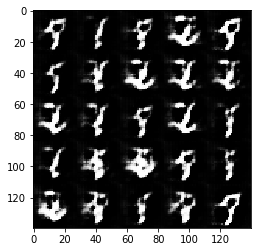

Epoch 2/2 Batch# 510... Discriminator Loss: 0.4296... Generator Loss: 3.6214
Epoch 2/2 Batch# 520... Discriminator Loss: 0.4678... Generator Loss: 3.3425
Epoch 2/2 Batch# 530... Discriminator Loss: 0.4813... Generator Loss: 2.9626
Epoch 2/2 Batch# 540... Discriminator Loss: 0.7015... Generator Loss: 2.1018
Epoch 2/2 Batch# 550... Discriminator Loss: 0.5360... Generator Loss: 2.8428
Epoch 2/2 Batch# 560... Discriminator Loss: 0.6305... Generator Loss: 3.1381
Epoch 2/2 Batch# 570... Discriminator Loss: 0.5497... Generator Loss: 2.5097
Epoch 2/2 Batch# 580... Discriminator Loss: 0.5135... Generator Loss: 3.2575
Epoch 2/2 Batch# 590... Discriminator Loss: 0.4551... Generator Loss: 3.2864
Epoch 2/2 Batch# 600... Discriminator Loss: 0.4589... Generator Loss: 2.8848


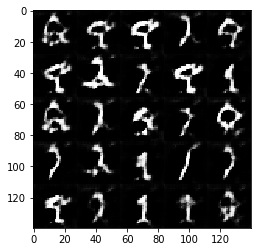

Epoch 2/2 Batch# 610... Discriminator Loss: 0.6061... Generator Loss: 2.6541
Epoch 2/2 Batch# 620... Discriminator Loss: 0.5644... Generator Loss: 2.6964
Epoch 2/2 Batch# 630... Discriminator Loss: 0.5907... Generator Loss: 4.0214
Epoch 2/2 Batch# 640... Discriminator Loss: 0.5083... Generator Loss: 3.3170
Epoch 2/2 Batch# 650... Discriminator Loss: 0.7041... Generator Loss: 2.8610
Epoch 2/2 Batch# 660... Discriminator Loss: 0.4936... Generator Loss: 2.9827
Epoch 2/2 Batch# 670... Discriminator Loss: 0.6123... Generator Loss: 4.0562
Epoch 2/2 Batch# 680... Discriminator Loss: 0.5908... Generator Loss: 2.0354
Epoch 2/2 Batch# 690... Discriminator Loss: 0.6410... Generator Loss: 4.2876
Epoch 2/2 Batch# 700... Discriminator Loss: 0.7151... Generator Loss: 1.7757


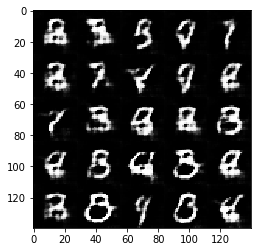

Epoch 2/2 Batch# 710... Discriminator Loss: 0.5221... Generator Loss: 2.9269
Epoch 2/2 Batch# 720... Discriminator Loss: 0.5678... Generator Loss: 2.0353
Epoch 2/2 Batch# 730... Discriminator Loss: 0.5771... Generator Loss: 2.5702
Epoch 2/2 Batch# 740... Discriminator Loss: 0.6677... Generator Loss: 2.7011
Epoch 2/2 Batch# 750... Discriminator Loss: 0.8365... Generator Loss: 1.6257
Epoch 2/2 Batch# 760... Discriminator Loss: 0.8182... Generator Loss: 2.4323
Epoch 2/2 Batch# 770... Discriminator Loss: 0.5883... Generator Loss: 3.3738
Epoch 2/2 Batch# 780... Discriminator Loss: 0.6729... Generator Loss: 3.0466
Epoch 2/2 Batch# 790... Discriminator Loss: 0.6541... Generator Loss: 2.2225
Epoch 2/2 Batch# 800... Discriminator Loss: 0.7579... Generator Loss: 1.5468


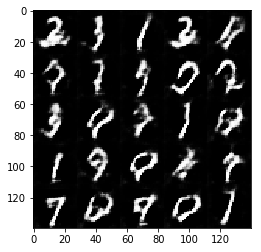

Epoch 2/2 Batch# 810... Discriminator Loss: 0.5986... Generator Loss: 3.7376
Epoch 2/2 Batch# 820... Discriminator Loss: 1.0079... Generator Loss: 4.4708
Epoch 2/2 Batch# 830... Discriminator Loss: 0.5710... Generator Loss: 2.5689
Epoch 2/2 Batch# 840... Discriminator Loss: 0.7553... Generator Loss: 2.7834
Epoch 2/2 Batch# 850... Discriminator Loss: 1.0352... Generator Loss: 1.1945
Epoch 2/2 Batch# 860... Discriminator Loss: 0.6427... Generator Loss: 2.0982
Epoch 2/2 Batch# 870... Discriminator Loss: 0.5876... Generator Loss: 2.6512
Epoch 2/2 Batch# 880... Discriminator Loss: 0.7517... Generator Loss: 4.6011
Epoch 2/2 Batch# 890... Discriminator Loss: 0.5803... Generator Loss: 2.4688
Epoch 2/2 Batch# 900... Discriminator Loss: 0.7579... Generator Loss: 1.8335


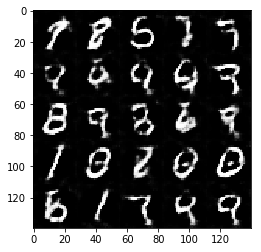

Epoch 2/2 Batch# 910... Discriminator Loss: 0.6696... Generator Loss: 2.2549
Epoch 2/2 Batch# 920... Discriminator Loss: 0.5560... Generator Loss: 3.4563
Epoch 2/2 Batch# 930... Discriminator Loss: 0.6381... Generator Loss: 3.7189


In [34]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 0.6722... Generator Loss: 1.8918
Epoch 1/1 Batch# 20... Discriminator Loss: 0.6007... Generator Loss: 2.3094
Epoch 1/1 Batch# 30... Discriminator Loss: 0.5264... Generator Loss: 2.9413
Epoch 1/1 Batch# 40... Discriminator Loss: 0.5785... Generator Loss: 3.4340
Epoch 1/1 Batch# 50... Discriminator Loss: 0.6108... Generator Loss: 2.4608
Epoch 1/1 Batch# 60... Discriminator Loss: 0.5475... Generator Loss: 3.5908
Epoch 1/1 Batch# 70... Discriminator Loss: 0.4775... Generator Loss: 4.1375
Epoch 1/1 Batch# 80... Discriminator Loss: 0.5207... Generator Loss: 2.6093
Epoch 1/1 Batch# 90... Discriminator Loss: 0.7566... Generator Loss: 1.8366
Epoch 1/1 Batch# 100... Discriminator Loss: 0.5687... Generator Loss: 2.9550


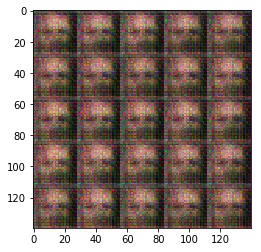

Epoch 1/1 Batch# 110... Discriminator Loss: 0.5194... Generator Loss: 4.3942
Epoch 1/1 Batch# 120... Discriminator Loss: 0.5360... Generator Loss: 3.2836
Epoch 1/1 Batch# 130... Discriminator Loss: 0.5350... Generator Loss: 3.4679
Epoch 1/1 Batch# 140... Discriminator Loss: 0.5324... Generator Loss: 4.1454
Epoch 1/1 Batch# 150... Discriminator Loss: 0.5004... Generator Loss: 3.1322
Epoch 1/1 Batch# 160... Discriminator Loss: 0.4672... Generator Loss: 4.4583
Epoch 1/1 Batch# 170... Discriminator Loss: 0.4595... Generator Loss: 3.8528
Epoch 1/1 Batch# 180... Discriminator Loss: 0.5293... Generator Loss: 3.2332
Epoch 1/1 Batch# 190... Discriminator Loss: 0.4413... Generator Loss: 4.2872
Epoch 1/1 Batch# 200... Discriminator Loss: 0.4329... Generator Loss: 4.9566


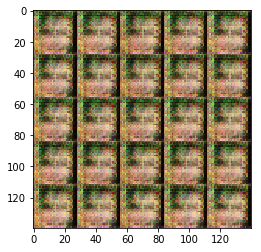

Epoch 1/1 Batch# 210... Discriminator Loss: 0.5101... Generator Loss: 3.3351
Epoch 1/1 Batch# 220... Discriminator Loss: 0.4356... Generator Loss: 4.9190
Epoch 1/1 Batch# 230... Discriminator Loss: 0.4415... Generator Loss: 4.6282
Epoch 1/1 Batch# 240... Discriminator Loss: 0.4386... Generator Loss: 3.5666
Epoch 1/1 Batch# 250... Discriminator Loss: 0.4609... Generator Loss: 3.4936
Epoch 1/1 Batch# 260... Discriminator Loss: 0.4725... Generator Loss: 3.2954
Epoch 1/1 Batch# 270... Discriminator Loss: 0.4563... Generator Loss: 3.7981
Epoch 1/1 Batch# 280... Discriminator Loss: 0.4152... Generator Loss: 4.8571
Epoch 1/1 Batch# 290... Discriminator Loss: 0.4789... Generator Loss: 3.7802
Epoch 1/1 Batch# 300... Discriminator Loss: 0.4447... Generator Loss: 4.2054


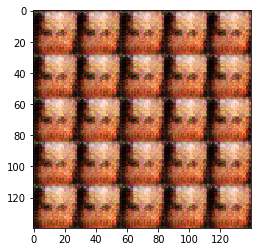

Epoch 1/1 Batch# 310... Discriminator Loss: 0.4196... Generator Loss: 4.5859
Epoch 1/1 Batch# 320... Discriminator Loss: 0.3916... Generator Loss: 4.3237
Epoch 1/1 Batch# 330... Discriminator Loss: 0.4278... Generator Loss: 4.1813
Epoch 1/1 Batch# 340... Discriminator Loss: 0.4039... Generator Loss: 4.2799
Epoch 1/1 Batch# 350... Discriminator Loss: 0.4530... Generator Loss: 4.6509
Epoch 1/1 Batch# 360... Discriminator Loss: 0.4421... Generator Loss: 4.0355
Epoch 1/1 Batch# 370... Discriminator Loss: 0.4117... Generator Loss: 5.2387
Epoch 1/1 Batch# 380... Discriminator Loss: 0.3983... Generator Loss: 4.1947
Epoch 1/1 Batch# 390... Discriminator Loss: 0.4000... Generator Loss: 5.1182
Epoch 1/1 Batch# 400... Discriminator Loss: 0.3914... Generator Loss: 4.8845


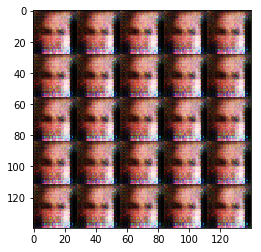

Epoch 1/1 Batch# 410... Discriminator Loss: 0.3753... Generator Loss: 4.7546
Epoch 1/1 Batch# 420... Discriminator Loss: 0.4047... Generator Loss: 4.4649
Epoch 1/1 Batch# 430... Discriminator Loss: 0.3962... Generator Loss: 4.4400
Epoch 1/1 Batch# 440... Discriminator Loss: 0.3772... Generator Loss: 5.0845
Epoch 1/1 Batch# 450... Discriminator Loss: 0.4238... Generator Loss: 4.2656
Epoch 1/1 Batch# 460... Discriminator Loss: 0.4138... Generator Loss: 3.8879
Epoch 1/1 Batch# 470... Discriminator Loss: 0.4089... Generator Loss: 4.0892
Epoch 1/1 Batch# 480... Discriminator Loss: 0.4059... Generator Loss: 4.5005
Epoch 1/1 Batch# 490... Discriminator Loss: 0.4325... Generator Loss: 4.0752
Epoch 1/1 Batch# 500... Discriminator Loss: 0.3833... Generator Loss: 4.7656


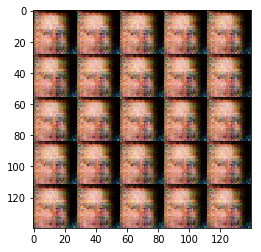

Epoch 1/1 Batch# 510... Discriminator Loss: 0.3662... Generator Loss: 4.9326
Epoch 1/1 Batch# 520... Discriminator Loss: 0.3729... Generator Loss: 4.9355
Epoch 1/1 Batch# 530... Discriminator Loss: 0.3732... Generator Loss: 4.8406
Epoch 1/1 Batch# 540... Discriminator Loss: 0.3936... Generator Loss: 4.3335
Epoch 1/1 Batch# 550... Discriminator Loss: 0.5099... Generator Loss: 2.8697
Epoch 1/1 Batch# 560... Discriminator Loss: 0.4828... Generator Loss: 3.0251
Epoch 1/1 Batch# 570... Discriminator Loss: 0.3949... Generator Loss: 3.8493
Epoch 1/1 Batch# 580... Discriminator Loss: 0.4512... Generator Loss: 2.5663
Epoch 1/1 Batch# 590... Discriminator Loss: 0.3834... Generator Loss: 4.3863
Epoch 1/1 Batch# 600... Discriminator Loss: 0.4041... Generator Loss: 4.0813


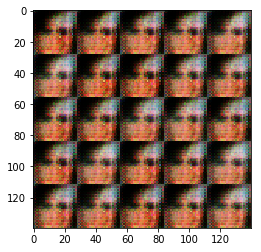

Epoch 1/1 Batch# 610... Discriminator Loss: 0.5101... Generator Loss: 3.8577
Epoch 1/1 Batch# 620... Discriminator Loss: 0.6326... Generator Loss: 2.1282
Epoch 1/1 Batch# 630... Discriminator Loss: 2.5251... Generator Loss: 7.3340
Epoch 1/1 Batch# 640... Discriminator Loss: 0.5640... Generator Loss: 2.9924
Epoch 1/1 Batch# 650... Discriminator Loss: 0.4723... Generator Loss: 3.4792
Epoch 1/1 Batch# 660... Discriminator Loss: 0.4151... Generator Loss: 4.4240
Epoch 1/1 Batch# 670... Discriminator Loss: 0.5480... Generator Loss: 2.9439
Epoch 1/1 Batch# 680... Discriminator Loss: 0.4391... Generator Loss: 3.6985
Epoch 1/1 Batch# 690... Discriminator Loss: 0.5112... Generator Loss: 3.0559
Epoch 1/1 Batch# 700... Discriminator Loss: 0.4634... Generator Loss: 2.8122


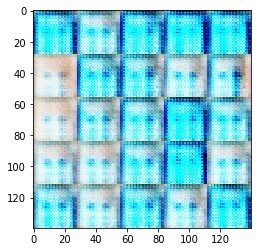

Epoch 1/1 Batch# 710... Discriminator Loss: 0.4277... Generator Loss: 3.5206
Epoch 1/1 Batch# 720... Discriminator Loss: 0.4481... Generator Loss: 3.6188
Epoch 1/1 Batch# 730... Discriminator Loss: 0.4321... Generator Loss: 4.2164
Epoch 1/1 Batch# 740... Discriminator Loss: 0.4327... Generator Loss: 3.7857
Epoch 1/1 Batch# 750... Discriminator Loss: 0.5050... Generator Loss: 2.9282
Epoch 1/1 Batch# 760... Discriminator Loss: 0.4865... Generator Loss: 3.3132
Epoch 1/1 Batch# 770... Discriminator Loss: 0.4523... Generator Loss: 4.0666
Epoch 1/1 Batch# 780... Discriminator Loss: 0.5144... Generator Loss: 6.1959
Epoch 1/1 Batch# 790... Discriminator Loss: 0.5432... Generator Loss: 2.7930
Epoch 1/1 Batch# 800... Discriminator Loss: 0.6697... Generator Loss: 2.3476


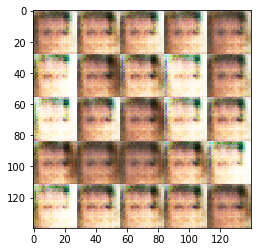

Epoch 1/1 Batch# 810... Discriminator Loss: 0.4417... Generator Loss: 3.8268
Epoch 1/1 Batch# 820... Discriminator Loss: 0.6070... Generator Loss: 5.8508
Epoch 1/1 Batch# 830... Discriminator Loss: 0.5451... Generator Loss: 2.3931
Epoch 1/1 Batch# 840... Discriminator Loss: 0.5432... Generator Loss: 3.2016
Epoch 1/1 Batch# 850... Discriminator Loss: 0.5319... Generator Loss: 3.0815
Epoch 1/1 Batch# 860... Discriminator Loss: 0.7390... Generator Loss: 1.8558
Epoch 1/1 Batch# 870... Discriminator Loss: 0.5372... Generator Loss: 3.6519
Epoch 1/1 Batch# 880... Discriminator Loss: 0.7978... Generator Loss: 1.7834
Epoch 1/1 Batch# 890... Discriminator Loss: 0.5626... Generator Loss: 3.9572
Epoch 1/1 Batch# 900... Discriminator Loss: 0.7656... Generator Loss: 6.3888


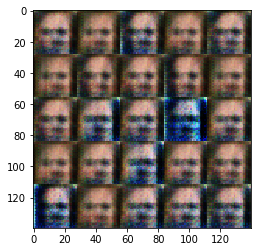

Epoch 1/1 Batch# 910... Discriminator Loss: 0.5742... Generator Loss: 2.4093
Epoch 1/1 Batch# 920... Discriminator Loss: 0.5817... Generator Loss: 2.9069
Epoch 1/1 Batch# 930... Discriminator Loss: 0.5282... Generator Loss: 3.8032
Epoch 1/1 Batch# 940... Discriminator Loss: 0.4889... Generator Loss: 3.7501
Epoch 1/1 Batch# 950... Discriminator Loss: 0.5391... Generator Loss: 3.6230
Epoch 1/1 Batch# 960... Discriminator Loss: 0.5906... Generator Loss: 5.1029
Epoch 1/1 Batch# 970... Discriminator Loss: 0.6000... Generator Loss: 2.9278
Epoch 1/1 Batch# 980... Discriminator Loss: 0.5237... Generator Loss: 3.3389
Epoch 1/1 Batch# 990... Discriminator Loss: 0.5763... Generator Loss: 2.8083
Epoch 1/1 Batch# 1000... Discriminator Loss: 0.5255... Generator Loss: 3.2154


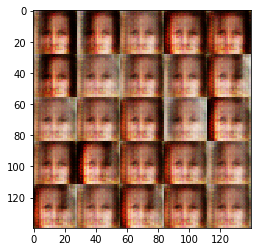

Epoch 1/1 Batch# 1010... Discriminator Loss: 0.4725... Generator Loss: 3.4448
Epoch 1/1 Batch# 1020... Discriminator Loss: 0.4361... Generator Loss: 3.4082
Epoch 1/1 Batch# 1030... Discriminator Loss: 0.5796... Generator Loss: 2.1897
Epoch 1/1 Batch# 1040... Discriminator Loss: 0.4747... Generator Loss: 3.4543
Epoch 1/1 Batch# 1050... Discriminator Loss: 0.6783... Generator Loss: 5.0311
Epoch 1/1 Batch# 1060... Discriminator Loss: 0.4906... Generator Loss: 3.0833
Epoch 1/1 Batch# 1070... Discriminator Loss: 0.4254... Generator Loss: 4.8254
Epoch 1/1 Batch# 1080... Discriminator Loss: 0.5563... Generator Loss: 2.4683
Epoch 1/1 Batch# 1090... Discriminator Loss: 0.4408... Generator Loss: 4.1821
Epoch 1/1 Batch# 1100... Discriminator Loss: 0.4547... Generator Loss: 3.3687


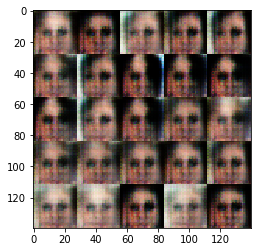

Epoch 1/1 Batch# 1110... Discriminator Loss: 0.5131... Generator Loss: 3.6830
Epoch 1/1 Batch# 1120... Discriminator Loss: 0.4142... Generator Loss: 4.4554
Epoch 1/1 Batch# 1130... Discriminator Loss: 0.5928... Generator Loss: 2.8430
Epoch 1/1 Batch# 1140... Discriminator Loss: 0.5253... Generator Loss: 3.2411
Epoch 1/1 Batch# 1150... Discriminator Loss: 0.4557... Generator Loss: 3.6396
Epoch 1/1 Batch# 1160... Discriminator Loss: 0.5027... Generator Loss: 2.9039
Epoch 1/1 Batch# 1170... Discriminator Loss: 0.4828... Generator Loss: 3.1254
Epoch 1/1 Batch# 1180... Discriminator Loss: 0.5262... Generator Loss: 3.9885
Epoch 1/1 Batch# 1190... Discriminator Loss: 0.6559... Generator Loss: 2.4043
Epoch 1/1 Batch# 1200... Discriminator Loss: 0.6194... Generator Loss: 2.6917


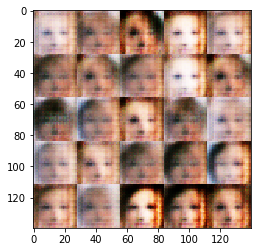

Epoch 1/1 Batch# 1210... Discriminator Loss: 0.4580... Generator Loss: 3.4598
Epoch 1/1 Batch# 1220... Discriminator Loss: 0.5077... Generator Loss: 2.9342
Epoch 1/1 Batch# 1230... Discriminator Loss: 0.8144... Generator Loss: 1.5008
Epoch 1/1 Batch# 1240... Discriminator Loss: 0.5835... Generator Loss: 2.6908
Epoch 1/1 Batch# 1250... Discriminator Loss: 0.7508... Generator Loss: 2.8149
Epoch 1/1 Batch# 1260... Discriminator Loss: 0.6852... Generator Loss: 1.9575
Epoch 1/1 Batch# 1270... Discriminator Loss: 0.5069... Generator Loss: 2.9994
Epoch 1/1 Batch# 1280... Discriminator Loss: 0.4675... Generator Loss: 3.7279
Epoch 1/1 Batch# 1290... Discriminator Loss: 0.4920... Generator Loss: 2.6562
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.4755... Generator Loss: 0.7037


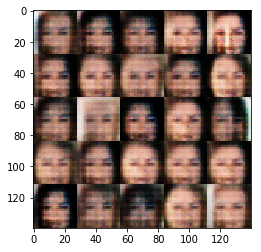

Epoch 1/1 Batch# 1310... Discriminator Loss: 0.4878... Generator Loss: 2.3176
Epoch 1/1 Batch# 1320... Discriminator Loss: 0.5223... Generator Loss: 2.8205
Epoch 1/1 Batch# 1330... Discriminator Loss: 0.5811... Generator Loss: 2.4180
Epoch 1/1 Batch# 1340... Discriminator Loss: 0.7044... Generator Loss: 1.8505
Epoch 1/1 Batch# 1350... Discriminator Loss: 0.5995... Generator Loss: 3.0981
Epoch 1/1 Batch# 1360... Discriminator Loss: 0.4337... Generator Loss: 4.1054
Epoch 1/1 Batch# 1370... Discriminator Loss: 0.4655... Generator Loss: 3.3981
Epoch 1/1 Batch# 1380... Discriminator Loss: 0.5869... Generator Loss: 2.2886
Epoch 1/1 Batch# 1390... Discriminator Loss: 0.6408... Generator Loss: 2.5516
Epoch 1/1 Batch# 1400... Discriminator Loss: 0.6527... Generator Loss: 5.3419


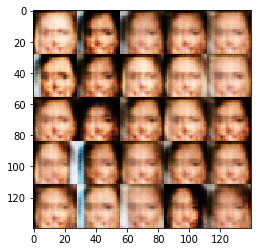

Epoch 1/1 Batch# 1410... Discriminator Loss: 0.5101... Generator Loss: 3.6720
Epoch 1/1 Batch# 1420... Discriminator Loss: 0.4797... Generator Loss: 3.2142
Epoch 1/1 Batch# 1430... Discriminator Loss: 0.4875... Generator Loss: 4.0250
Epoch 1/1 Batch# 1440... Discriminator Loss: 0.5617... Generator Loss: 2.2764
Epoch 1/1 Batch# 1450... Discriminator Loss: 0.4605... Generator Loss: 3.3564
Epoch 1/1 Batch# 1460... Discriminator Loss: 0.4796... Generator Loss: 3.8897
Epoch 1/1 Batch# 1470... Discriminator Loss: 0.5259... Generator Loss: 2.8409
Epoch 1/1 Batch# 1480... Discriminator Loss: 0.8051... Generator Loss: 1.6639
Epoch 1/1 Batch# 1490... Discriminator Loss: 0.6174... Generator Loss: 2.2942
Epoch 1/1 Batch# 1500... Discriminator Loss: 0.7300... Generator Loss: 1.7174


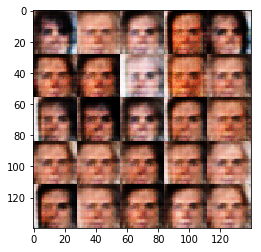

Epoch 1/1 Batch# 1510... Discriminator Loss: 0.6790... Generator Loss: 3.9056
Epoch 1/1 Batch# 1520... Discriminator Loss: 0.4942... Generator Loss: 3.2882
Epoch 1/1 Batch# 1530... Discriminator Loss: 0.6259... Generator Loss: 2.4519
Epoch 1/1 Batch# 1540... Discriminator Loss: 0.4940... Generator Loss: 2.8986
Epoch 1/1 Batch# 1550... Discriminator Loss: 0.6522... Generator Loss: 2.0578
Epoch 1/1 Batch# 1560... Discriminator Loss: 0.6255... Generator Loss: 2.3485
Epoch 1/1 Batch# 1570... Discriminator Loss: 0.5408... Generator Loss: 4.5224
Epoch 1/1 Batch# 1580... Discriminator Loss: 0.7245... Generator Loss: 4.4215
Epoch 1/1 Batch# 1590... Discriminator Loss: 0.5361... Generator Loss: 2.4662
Epoch 1/1 Batch# 1600... Discriminator Loss: 0.5419... Generator Loss: 3.2858


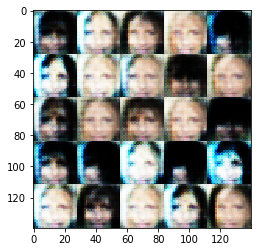

Epoch 1/1 Batch# 1610... Discriminator Loss: 0.5982... Generator Loss: 2.1060
Epoch 1/1 Batch# 1620... Discriminator Loss: 0.4752... Generator Loss: 2.9831
Epoch 1/1 Batch# 1630... Discriminator Loss: 0.6064... Generator Loss: 2.1562
Epoch 1/1 Batch# 1640... Discriminator Loss: 0.4676... Generator Loss: 3.4501
Epoch 1/1 Batch# 1650... Discriminator Loss: 0.4508... Generator Loss: 3.8635
Epoch 1/1 Batch# 1660... Discriminator Loss: 0.6526... Generator Loss: 3.7747
Epoch 1/1 Batch# 1670... Discriminator Loss: 0.4839... Generator Loss: 3.0608
Epoch 1/1 Batch# 1680... Discriminator Loss: 0.7071... Generator Loss: 2.3585
Epoch 1/1 Batch# 1690... Discriminator Loss: 0.5832... Generator Loss: 2.9615
Epoch 1/1 Batch# 1700... Discriminator Loss: 0.7335... Generator Loss: 2.2931


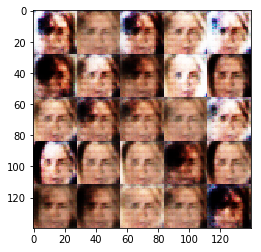

Epoch 1/1 Batch# 1710... Discriminator Loss: 0.4740... Generator Loss: 3.8336
Epoch 1/1 Batch# 1720... Discriminator Loss: 0.6261... Generator Loss: 4.6813
Epoch 1/1 Batch# 1730... Discriminator Loss: 0.6321... Generator Loss: 2.3464
Epoch 1/1 Batch# 1740... Discriminator Loss: 0.6735... Generator Loss: 1.8418
Epoch 1/1 Batch# 1750... Discriminator Loss: 0.5218... Generator Loss: 3.7685
Epoch 1/1 Batch# 1760... Discriminator Loss: 0.5175... Generator Loss: 3.2854
Epoch 1/1 Batch# 1770... Discriminator Loss: 0.5198... Generator Loss: 2.8888
Epoch 1/1 Batch# 1780... Discriminator Loss: 0.4898... Generator Loss: 3.2828
Epoch 1/1 Batch# 1790... Discriminator Loss: 0.5408... Generator Loss: 3.2964
Epoch 1/1 Batch# 1800... Discriminator Loss: 0.6464... Generator Loss: 3.6189


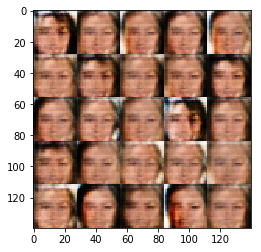

Epoch 1/1 Batch# 1810... Discriminator Loss: 0.5599... Generator Loss: 3.0729
Epoch 1/1 Batch# 1820... Discriminator Loss: 0.6226... Generator Loss: 2.4495
Epoch 1/1 Batch# 1830... Discriminator Loss: 1.2102... Generator Loss: 6.0612
Epoch 1/1 Batch# 1840... Discriminator Loss: 0.6053... Generator Loss: 2.6205
Epoch 1/1 Batch# 1850... Discriminator Loss: 0.6596... Generator Loss: 2.1421
Epoch 1/1 Batch# 1860... Discriminator Loss: 0.7264... Generator Loss: 2.1464
Epoch 1/1 Batch# 1870... Discriminator Loss: 0.5259... Generator Loss: 3.2273
Epoch 1/1 Batch# 1880... Discriminator Loss: 0.5633... Generator Loss: 2.9751
Epoch 1/1 Batch# 1890... Discriminator Loss: 0.5657... Generator Loss: 2.6937
Epoch 1/1 Batch# 1900... Discriminator Loss: 0.5971... Generator Loss: 2.5327


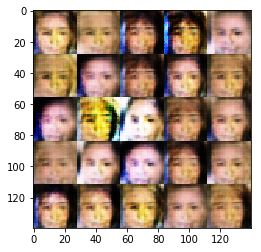

Epoch 1/1 Batch# 1910... Discriminator Loss: 0.5411... Generator Loss: 2.9898
Epoch 1/1 Batch# 1920... Discriminator Loss: 0.6569... Generator Loss: 2.0621
Epoch 1/1 Batch# 1930... Discriminator Loss: 0.5670... Generator Loss: 2.6929
Epoch 1/1 Batch# 1940... Discriminator Loss: 0.7011... Generator Loss: 2.7414
Epoch 1/1 Batch# 1950... Discriminator Loss: 0.4798... Generator Loss: 2.8260
Epoch 1/1 Batch# 1960... Discriminator Loss: 0.5149... Generator Loss: 2.4498
Epoch 1/1 Batch# 1970... Discriminator Loss: 0.5387... Generator Loss: 2.6591
Epoch 1/1 Batch# 1980... Discriminator Loss: 0.4789... Generator Loss: 3.1086
Epoch 1/1 Batch# 1990... Discriminator Loss: 0.8430... Generator Loss: 1.5870
Epoch 1/1 Batch# 2000... Discriminator Loss: 0.5044... Generator Loss: 3.0109


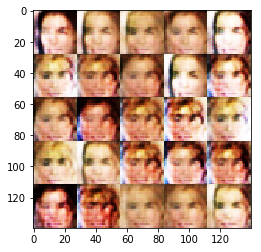

Epoch 1/1 Batch# 2010... Discriminator Loss: 0.5294... Generator Loss: 2.5178
Epoch 1/1 Batch# 2020... Discriminator Loss: 0.7665... Generator Loss: 2.4958
Epoch 1/1 Batch# 2030... Discriminator Loss: 0.5909... Generator Loss: 2.9158
Epoch 1/1 Batch# 2040... Discriminator Loss: 0.4831... Generator Loss: 3.3848
Epoch 1/1 Batch# 2050... Discriminator Loss: 0.4819... Generator Loss: 2.6395
Epoch 1/1 Batch# 2060... Discriminator Loss: 0.5419... Generator Loss: 2.9727
Epoch 1/1 Batch# 2070... Discriminator Loss: 0.5843... Generator Loss: 3.2387
Epoch 1/1 Batch# 2080... Discriminator Loss: 0.6171... Generator Loss: 2.6702
Epoch 1/1 Batch# 2090... Discriminator Loss: 0.5958... Generator Loss: 2.7783
Epoch 1/1 Batch# 2100... Discriminator Loss: 0.5692... Generator Loss: 2.4796


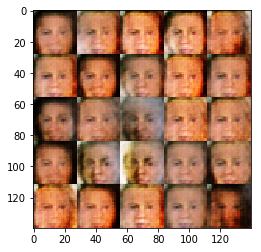

Epoch 1/1 Batch# 2110... Discriminator Loss: 0.6468... Generator Loss: 2.4220
Epoch 1/1 Batch# 2120... Discriminator Loss: 0.7609... Generator Loss: 1.5305
Epoch 1/1 Batch# 2130... Discriminator Loss: 0.4847... Generator Loss: 3.2784
Epoch 1/1 Batch# 2140... Discriminator Loss: 0.5641... Generator Loss: 3.7864
Epoch 1/1 Batch# 2150... Discriminator Loss: 0.6820... Generator Loss: 3.7197
Epoch 1/1 Batch# 2160... Discriminator Loss: 0.5970... Generator Loss: 3.2074
Epoch 1/1 Batch# 2170... Discriminator Loss: 0.5422... Generator Loss: 2.9684
Epoch 1/1 Batch# 2180... Discriminator Loss: 0.6208... Generator Loss: 2.3739
Epoch 1/1 Batch# 2190... Discriminator Loss: 0.6108... Generator Loss: 3.1929
Epoch 1/1 Batch# 2200... Discriminator Loss: 0.6900... Generator Loss: 2.2497


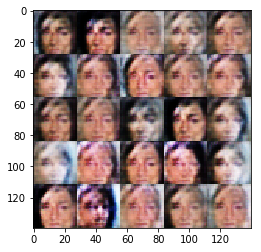

Epoch 1/1 Batch# 2210... Discriminator Loss: 0.6342... Generator Loss: 2.7886
Epoch 1/1 Batch# 2220... Discriminator Loss: 0.6544... Generator Loss: 2.3651
Epoch 1/1 Batch# 2230... Discriminator Loss: 0.6354... Generator Loss: 3.2363
Epoch 1/1 Batch# 2240... Discriminator Loss: 0.7143... Generator Loss: 2.5487
Epoch 1/1 Batch# 2250... Discriminator Loss: 0.6020... Generator Loss: 2.9010
Epoch 1/1 Batch# 2260... Discriminator Loss: 0.5905... Generator Loss: 2.6725
Epoch 1/1 Batch# 2270... Discriminator Loss: 0.5526... Generator Loss: 3.6812
Epoch 1/1 Batch# 2280... Discriminator Loss: 0.4828... Generator Loss: 3.0963
Epoch 1/1 Batch# 2290... Discriminator Loss: 0.5203... Generator Loss: 3.5463
Epoch 1/1 Batch# 2300... Discriminator Loss: 0.5703... Generator Loss: 3.4513


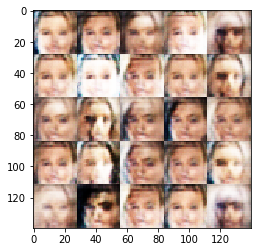

Epoch 1/1 Batch# 2310... Discriminator Loss: 0.5868... Generator Loss: 3.3954
Epoch 1/1 Batch# 2320... Discriminator Loss: 0.5786... Generator Loss: 3.4378
Epoch 1/1 Batch# 2330... Discriminator Loss: 0.5396... Generator Loss: 3.0589
Epoch 1/1 Batch# 2340... Discriminator Loss: 0.4559... Generator Loss: 3.3362
Epoch 1/1 Batch# 2350... Discriminator Loss: 0.6085... Generator Loss: 3.5891
Epoch 1/1 Batch# 2360... Discriminator Loss: 0.6456... Generator Loss: 2.4771
Epoch 1/1 Batch# 2370... Discriminator Loss: 0.5120... Generator Loss: 4.6183
Epoch 1/1 Batch# 2380... Discriminator Loss: 0.6140... Generator Loss: 3.2098
Epoch 1/1 Batch# 2390... Discriminator Loss: 0.4867... Generator Loss: 3.4265
Epoch 1/1 Batch# 2400... Discriminator Loss: 0.6490... Generator Loss: 3.0953


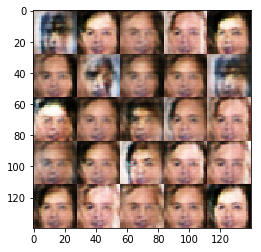

Epoch 1/1 Batch# 2410... Discriminator Loss: 0.5515... Generator Loss: 3.0085
Epoch 1/1 Batch# 2420... Discriminator Loss: 0.5816... Generator Loss: 2.8016
Epoch 1/1 Batch# 2430... Discriminator Loss: 0.8518... Generator Loss: 1.7485
Epoch 1/1 Batch# 2440... Discriminator Loss: 0.5542... Generator Loss: 3.0201
Epoch 1/1 Batch# 2450... Discriminator Loss: 0.5596... Generator Loss: 3.2567
Epoch 1/1 Batch# 2460... Discriminator Loss: 0.5019... Generator Loss: 3.2118
Epoch 1/1 Batch# 2470... Discriminator Loss: 0.5782... Generator Loss: 2.1954
Epoch 1/1 Batch# 2480... Discriminator Loss: 0.6277... Generator Loss: 2.2990
Epoch 1/1 Batch# 2490... Discriminator Loss: 0.6702... Generator Loss: 1.8989
Epoch 1/1 Batch# 2500... Discriminator Loss: 0.6370... Generator Loss: 3.3552


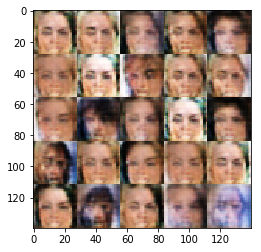

Epoch 1/1 Batch# 2510... Discriminator Loss: 0.4871... Generator Loss: 2.9410
Epoch 1/1 Batch# 2520... Discriminator Loss: 0.6335... Generator Loss: 2.9209
Epoch 1/1 Batch# 2530... Discriminator Loss: 0.6102... Generator Loss: 2.7037
Epoch 1/1 Batch# 2540... Discriminator Loss: 0.5521... Generator Loss: 2.8340
Epoch 1/1 Batch# 2550... Discriminator Loss: 0.6521... Generator Loss: 3.0589
Epoch 1/1 Batch# 2560... Discriminator Loss: 0.7071... Generator Loss: 3.6700
Epoch 1/1 Batch# 2570... Discriminator Loss: 0.7618... Generator Loss: 2.1697
Epoch 1/1 Batch# 2580... Discriminator Loss: 0.5204... Generator Loss: 3.1632
Epoch 1/1 Batch# 2590... Discriminator Loss: 0.5344... Generator Loss: 3.4326
Epoch 1/1 Batch# 2600... Discriminator Loss: 0.7476... Generator Loss: 1.8435


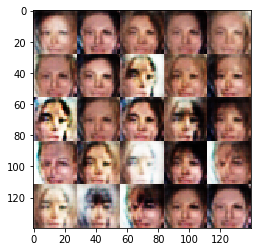

Epoch 1/1 Batch# 2610... Discriminator Loss: 0.5756... Generator Loss: 2.9555
Epoch 1/1 Batch# 2620... Discriminator Loss: 0.5173... Generator Loss: 3.6790
Epoch 1/1 Batch# 2630... Discriminator Loss: 0.5679... Generator Loss: 2.8744
Epoch 1/1 Batch# 2640... Discriminator Loss: 0.5032... Generator Loss: 3.6124
Epoch 1/1 Batch# 2650... Discriminator Loss: 0.8330... Generator Loss: 1.5356
Epoch 1/1 Batch# 2660... Discriminator Loss: 0.7245... Generator Loss: 2.3475
Epoch 1/1 Batch# 2670... Discriminator Loss: 0.4826... Generator Loss: 3.5039
Epoch 1/1 Batch# 2680... Discriminator Loss: 0.6507... Generator Loss: 2.2034
Epoch 1/1 Batch# 2690... Discriminator Loss: 0.5772... Generator Loss: 3.6168
Epoch 1/1 Batch# 2700... Discriminator Loss: 0.7473... Generator Loss: 2.2243


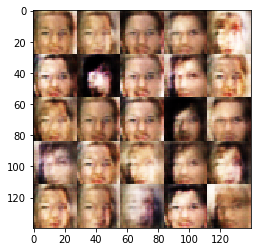

Epoch 1/1 Batch# 2710... Discriminator Loss: 0.6816... Generator Loss: 4.0236
Epoch 1/1 Batch# 2720... Discriminator Loss: 0.6544... Generator Loss: 2.2216
Epoch 1/1 Batch# 2730... Discriminator Loss: 0.5340... Generator Loss: 3.6893
Epoch 1/1 Batch# 2740... Discriminator Loss: 0.5082... Generator Loss: 2.4873
Epoch 1/1 Batch# 2750... Discriminator Loss: 0.5762... Generator Loss: 2.7450
Epoch 1/1 Batch# 2760... Discriminator Loss: 0.6105... Generator Loss: 2.5195
Epoch 1/1 Batch# 2770... Discriminator Loss: 0.4622... Generator Loss: 2.5544
Epoch 1/1 Batch# 2780... Discriminator Loss: 0.8571... Generator Loss: 1.3666
Epoch 1/1 Batch# 2790... Discriminator Loss: 0.4858... Generator Loss: 3.2860
Epoch 1/1 Batch# 2800... Discriminator Loss: 0.6308... Generator Loss: 5.2281


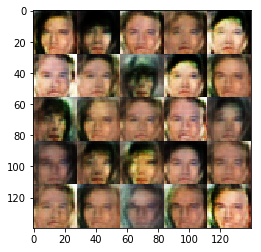

Epoch 1/1 Batch# 2810... Discriminator Loss: 0.5326... Generator Loss: 2.5228
Epoch 1/1 Batch# 2820... Discriminator Loss: 0.6227... Generator Loss: 2.4971
Epoch 1/1 Batch# 2830... Discriminator Loss: 0.6018... Generator Loss: 2.1202
Epoch 1/1 Batch# 2840... Discriminator Loss: 0.6435... Generator Loss: 2.2910
Epoch 1/1 Batch# 2850... Discriminator Loss: 0.5446... Generator Loss: 2.4294
Epoch 1/1 Batch# 2860... Discriminator Loss: 0.5274... Generator Loss: 2.6497
Epoch 1/1 Batch# 2870... Discriminator Loss: 0.9985... Generator Loss: 4.1339
Epoch 1/1 Batch# 2880... Discriminator Loss: 0.6684... Generator Loss: 2.7123
Epoch 1/1 Batch# 2890... Discriminator Loss: 0.5804... Generator Loss: 2.3758
Epoch 1/1 Batch# 2900... Discriminator Loss: 0.5892... Generator Loss: 2.8109


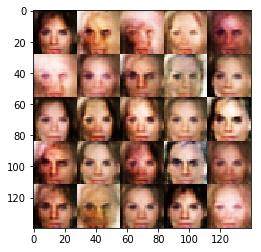

Epoch 1/1 Batch# 2910... Discriminator Loss: 0.6296... Generator Loss: 1.9898
Epoch 1/1 Batch# 2920... Discriminator Loss: 0.5963... Generator Loss: 2.7271
Epoch 1/1 Batch# 2930... Discriminator Loss: 0.5121... Generator Loss: 5.0429
Epoch 1/1 Batch# 2940... Discriminator Loss: 0.5447... Generator Loss: 3.0110
Epoch 1/1 Batch# 2950... Discriminator Loss: 0.6458... Generator Loss: 2.3179
Epoch 1/1 Batch# 2960... Discriminator Loss: 0.6565... Generator Loss: 2.0982
Epoch 1/1 Batch# 2970... Discriminator Loss: 0.6568... Generator Loss: 3.2306
Epoch 1/1 Batch# 2980... Discriminator Loss: 0.7539... Generator Loss: 3.0802
Epoch 1/1 Batch# 2990... Discriminator Loss: 0.5571... Generator Loss: 2.9374
Epoch 1/1 Batch# 3000... Discriminator Loss: 0.5102... Generator Loss: 2.7345


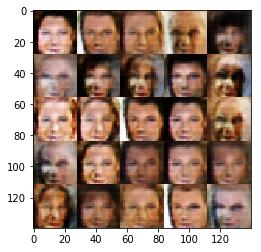

Epoch 1/1 Batch# 3010... Discriminator Loss: 0.6749... Generator Loss: 2.4422
Epoch 1/1 Batch# 3020... Discriminator Loss: 0.5285... Generator Loss: 3.2636
Epoch 1/1 Batch# 3030... Discriminator Loss: 0.5220... Generator Loss: 2.6959
Epoch 1/1 Batch# 3040... Discriminator Loss: 0.6623... Generator Loss: 3.1794
Epoch 1/1 Batch# 3050... Discriminator Loss: 0.5985... Generator Loss: 3.5457
Epoch 1/1 Batch# 3060... Discriminator Loss: 0.4712... Generator Loss: 3.8024
Epoch 1/1 Batch# 3070... Discriminator Loss: 0.5055... Generator Loss: 2.6699
Epoch 1/1 Batch# 3080... Discriminator Loss: 0.6007... Generator Loss: 2.6556
Epoch 1/1 Batch# 3090... Discriminator Loss: 0.7035... Generator Loss: 3.7549
Epoch 1/1 Batch# 3100... Discriminator Loss: 0.7363... Generator Loss: 2.1965


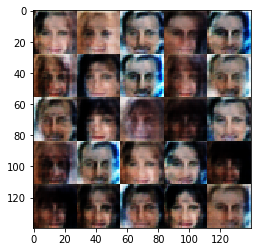

Epoch 1/1 Batch# 3110... Discriminator Loss: 0.7322... Generator Loss: 2.0429
Epoch 1/1 Batch# 3120... Discriminator Loss: 0.5971... Generator Loss: 2.3558
Epoch 1/1 Batch# 3130... Discriminator Loss: 0.5465... Generator Loss: 2.6732
Epoch 1/1 Batch# 3140... Discriminator Loss: 0.5500... Generator Loss: 3.2680
Epoch 1/1 Batch# 3150... Discriminator Loss: 0.4499... Generator Loss: 4.2132
Epoch 1/1 Batch# 3160... Discriminator Loss: 0.5428... Generator Loss: 3.0293


In [36]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.